In [2]:
import warnings
warnings.filterwarnings('ignore')

from module_data_info import data_module_chl, biomes_module
from module_data_locations import *
from module_data_load import load_data, load_ensemble, load_biomes
from module_data_preprocessing import * 
from module_data_postprocessing import * 
from module_global_averages import * 
from module_metrics import *
from module_plot_lines import *
from module_plot_maps  import *
from module_plot_bars  import plot_bars

In [ ]:
# print(dir_forecasts_tos)
print(dir_observations_tos)
# print(dir_assimilations_tos)


In [12]:
dir_observations_tos = "/space/hall5/sitestore/eccc/crd/ccrn/users/rpg002/data/tos/observation/ERSST_v5_tos_1900-2022_1x1.nc"
obs_in = load_data(dir_observations_tos, 'tos')

In [154]:
dir_assim_tos = "/space/hall5/sitestore/eccc/crd/ccrn/users/rpg002/data/tos/assimilation/tos_Omon_ensmebles_195801_202012_1x1_LE.nc"
asm_in = load_data(dir_assim_tos, 'tos', ensemble_mean=True) 

loading data..
done


In [155]:
asm_in

<xarray.DataArray 'tos' (year: 63, time: 12, lat: 180, lon: 360)>
array([[[[       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         ...,
         [-1.7767906, -1.7764885, -1.7761818, ..., -1.7776718,
          -1.7773819, -1.7770884],
         [-1.7783161, -1.7781677, -1.7780192, ..., -1.7787626,
          -1.778614 , -1.7784649],
         [-1.7789418, -1.778928 , -1.7788956, ..., -1.7789816,
          -1.7789686, -1.7789555]],

        [[       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
...
         [-1.7690665, -1.7690254, -1.7689831, ..., -1.7691835,
          -1.7691457, -1.7691065],
         [-1.7706382, -1.7708366, -1.7710407, ..., -1.7700784,
          -1.7702583, -1.7704456],
         [-1.7786719, -1.7788674, -1.7789522, ..., -1.7780745,
          -1.7782751, -1.7784745]],

        [[       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         ...,
         [-1.7710873, -1.7709668, -1.7708406, ..., -1.7714186,
          -1.7713127, -1.7712027],
         [-1.773649 , -1.7737128, -1.7737811, ..., -1.7734829,
          -1.7735345, -1.7735897],
         [-1.7800055, -1.7800564, -1.780092 , ..., -1.7798545,
          -1.7799041, -1.7799543]]]], dtype=float32)
Coordinates:
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * time     (time) int64 0 1 2 3 4 5 6 7 8 9 10 11
  * year     (year) int64 1958 1959 1960 1961 1962 ... 2016 2017 2018 2019 2020

In [146]:

def Enso(tos):
    ds = tos.where((tos.lat >= -5) & (tos.lat <= 5), drop = True)
    ds = ds.where((ds.lon >= -170) & (ds.lon <= -120), drop = True)
    ds = ds.mean(['lat','lon'])

    y0 = ds.year.values[0]
    y1 = ds.year.values[-1]

    i, r = np.divmod(y0, 5)
    i = i if r == 0 else i+1

    base = ds.sel(year = slice(i * 5 + 1, None))
    clim  = [base[i : i +30,...] for i in range(0, len(base.sel(year = slice(None, 1991)).year), 5)]
    clim = xr.concat([xr.concat([ds.mean('year').assign_coords(year = ds.year.values[0] + 14 + ind) for ind in range(5)], dim = 'year') for ds in clim], dim = 'year')
    ext = xr.concat([clim[-1].assign_coords(year = yr ) for yr in range(clim.year.values[-1]+1, y1+1 ) ], dim = 'year')
    clim = xr.concat([clim, ext], dim = 'year')
    
    ONI_anoms = (ds - clim)
    ONI = ONI_anoms.stack(ref = ('year','time') ).rolling(ref =3, center = True).mean().unstack()
    return ONI



In [168]:
Enso(obs_in).to_netcdf('ERSST_v5_ONI_1915-2021.nc')
ens_obs = Enso(obs_in).sel(year = slice(1990,2020)).stack( ref = ('year','time'))
ens_obs = ens_obs.assign_coords(ref = ens_obs.year + ens_obs.time/12)

Enso(asm_in).to_netcdf('CanESM5_assim_ONI_1975-2020.nc')
ens_assm = Enso(asm_in).sel(year = slice(1990,2020)).stack( ref = ('year','time'))
ens_assm = ens_assm.assign_coords(ref = ens_assm.year+ ens_assm.time/12)

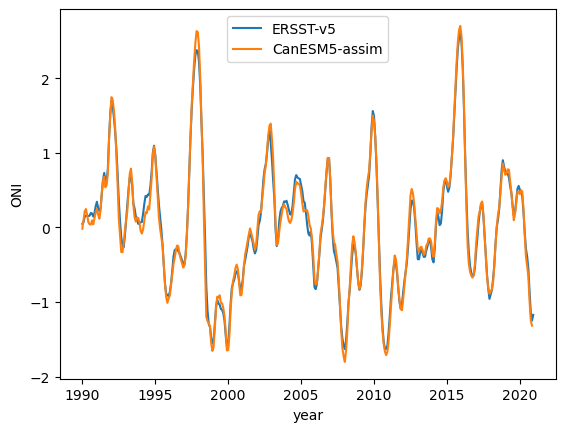

: 

In [173]:
ens_obs.plot(label = 'ERSST-v5')
ens_assm.plot(label = 'CanESM5-assim')
plt.ylabel('ONI')
plt.xlabel('year')
plt.legend()